# Tarea 6
## Francisco Javier Peralta Ramírez

Para el problema IMDB, construya una red de dos canales, una Recurrente y otra Densa. La recurrente procesa datos previamente "incrustados" y la densa considera un vectopr de tamaño a lo mas 10,000 con estras binarias que indicas si la palabra con dicho índice es contenida en la reseña (red de dos entradas). La red tienen un sola salida que significa la interpretación del sentir (positivo o negativo). Usar API de Kreras

In [8]:
import time
import keras

import matplotlib.pyplot as plt

from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense, Embedding, SimpleRNN, CuDNNLSTM
from keras.models import Sequential

Podemos generar una red neuronal reccurente y ver como se comporta con los datos de IMDB

In [2]:
max_features = 10000  # tamaño del diccionario de palabras comunes
                      # (número de palabras a utilizar)
maxlen = 500          # longitud máxima de cada secuencia 
batch_size = 32

print('Cargando Datos...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'Secuencia de entrenamiento')
print(len(input_test),  'Secuencia de prueba')

print('*Pad* de las secuencias (muestras x longitud)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('Forma de input_train:', input_train.shape)
print('Forma de input_test:', input_test.shape)

Cargando Datos...
25000 Secuencia de entrenamiento
25000 Secuencia de prueba
*Pad* de las secuencias (muestras x longitud)
Forma de input_train: (25000, 500)
Forma de input_test: (25000, 500)


In [9]:
model = Sequential()
# Capa embedding
# input_dim : tamaño del vocabulario
# output_dim: dimensión del vector al que se mapea
model.add(Embedding(input_dim=max_features, output_dim=32))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 328,481
Trainable params: 328,481
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['acc'])

In [11]:
tic = time.time()
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=2)
print('Tiempo de entrenamiento:', time.time()-tic)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 6s - loss: 0.5009 - acc: 0.7596 - val_loss: 0.4554 - val_acc: 0.7880
Epoch 2/10
 - 4s - loss: 0.3031 - acc: 0.8808 - val_loss: 0.3225 - val_acc: 0.8646
Epoch 3/10
 - 4s - loss: 0.2451 - acc: 0.9068 - val_loss: 0.3705 - val_acc: 0.8672
Epoch 4/10
 - 4s - loss: 0.2145 - acc: 0.9198 - val_loss: 0.3158 - val_acc: 0.8618
Epoch 5/10
 - 4s - loss: 0.1899 - acc: 0.9308 - val_loss: 0.3067 - val_acc: 0.8854
Epoch 6/10
 - 4s - loss: 0.1706 - acc: 0.9381 - val_loss: 0.4118 - val_acc: 0.8518
Epoch 7/10
 - 4s - loss: 0.1546 - acc: 0.9444 - val_loss: 0.3479 - val_acc: 0.8826
Epoch 8/10
 - 4s - loss: 0.1422 - acc: 0.9489 - val_loss: 0.3194 - val_acc: 0.8734
Epoch 9/10
 - 4s - loss: 0.1312 - acc: 0.9539 - val_loss: 0.4899 - val_acc: 0.8144
Epoch 10/10
 - 4s - loss: 0.1215 - acc: 0.9576 - val_loss: 0.3871 - val_acc: 0.8752
Tiempo de entrenamiento: 41.49244213104248


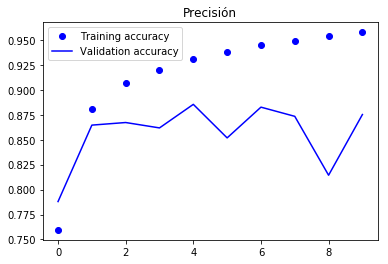

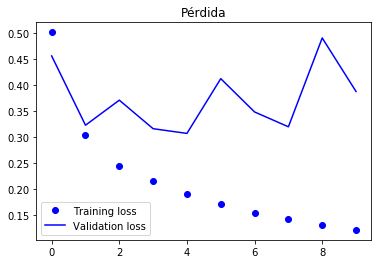

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Precisión')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Pérdida')
plt.legend()

plt.show()

Podemos hacer lo mismo con una red nuronal densa

In [7]:
denseNN = Sequential()
denseNN.add(Dense(32, input_dim=max_features))